# Libraries

In [1]:
# Standard Library Imports
import os
import sys
import json
import ssl
import shutil
from pathlib import Path
from collections import defaultdict
from random import sample
from typing import Any

ssl._create_default_https_context = ssl._create_unverified_context  # Ignore SSL certificate verification

# Data Science Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, show
import seaborn as sns

# Deep Learning Libraries - TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import Sequential, Input, layers, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dropout, Dense,
    BatchNormalization, RandomFlip, RandomRotation,
    RandomZoom, Rescaling
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.applications import EfficientNetB3

# Alternative: Standalone Keras Imports
from keras import Model, Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from keras.utils import to_categorical
from keras.datasets.cifar10 import load_data as load_cifar10
from keras_tqdm import TQDMCallback


# Deep Learning Libraries - PyTorch and Torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

# Machine Learning Libraries - scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Utility Libraries
from PIL import Image
from tqdm import tqdm
import open_clip
from torchvision.datasets import ImageFolder
import random
import cv2


# Import file csv (from Data No Noise)

In [2]:
df = pd.read_csv(r'/Users/ricardokayseller/Desktop/filtered_dataset.csv', sep= ',')

In [3]:
df.head(5)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path,full_path,label
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...,/Users/ricardokayseller/Desktop/DATA2/mollusca...,unionidae
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...,/Users/ricardokayseller/Desktop/DATA2/chordata...,geoemydidae
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...,/Users/ricardokayseller/Desktop/DATA2/chordata...,cryptobranchidae
3,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...,/Users/ricardokayseller/Desktop/DATA2/chordata...,indriidae
4,dc48f2ce-4feb-4ef7-b2a2-c3c3f42bf19b,28657539,491832,animalia,arthropoda,formicidae,arthropoda_formicidae/28657539_491832_eol-full...,/Users/ricardokayseller/Desktop/DATA2/arthropo...,formicidae


# 1. Update Path

In [4]:
# Update 'full_path' to point to the new directory
df['full_path'] = df['full_path'].str.replace(
    '/Users/ricardokayseller/Desktop/DATA2', 
    '/Users/ricardokayseller/Desktop/DATA_NO_NOISE_RESIZED_AUGMENTATION'
)

In [5]:
df.head(3)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path,full_path,label
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...,/Users/ricardokayseller/Desktop/DATA_NO_NOISE_...,unionidae
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...,/Users/ricardokayseller/Desktop/DATA_NO_NOISE_...,geoemydidae
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...,/Users/ricardokayseller/Desktop/DATA_NO_NOISE_...,cryptobranchidae


# 2. Check images in the path

In [6]:
# Path with images
DATA_DIR = "/Users/ricardokayseller/Desktop/DATA_NO_NOISE_RESIZED_AUGMENTATION"

def check_images_existence(df, data_dir):
    missing_files = []

    for path in df['full_path']:
        full_path = os.path.join(data_dir, path)
        if not os.path.exists(full_path):
            missing_files.append(full_path)

    if missing_files:
        print(f"\n {len(missing_files)} no files:\n")
        for file in missing_files:
            print(file)
    else:
        print("\n All images exist in path!")

check_images_existence(df, DATA_DIR)



 All images exist in path!


# 3. Verifying the Target Distribution

In [10]:
# Contar número de famílias com mais de 100 imagens
family_counts = df['family'].value_counts()
above_100 = family_counts[family_counts > 60]

print(f"Número de famílias com mais de 100 imagens: {len(above_100)}")
print(above_100)



Número de famílias com mais de 100 imagens: 37
family
dactyloidae        282
salamandridae      256
formicidae         249
cercopithecidae    242
carcharhinidae     242
plethodontidae     237
bovidae            232
acroporidae        207
bucerotidae        177
diomedeidae        153
anatidae           140
laridae            130
dasyatidae         128
bufonidae          119
iguanidae          119
spheniscidae       118
atelidae           116
agariciidae        112
delphinidae         96
accipitridae        94
psittacidae         90
callitrichidae      90
euphylliidae        90
mustelidae          90
geoemydidae         88
cebidae             88
ranidae             85
colubridae          81
rajidae             80
serranidae          77
ciconiidae          76
sphyrnidae          76
myliobatidae        75
trochilidae         73
thraupidae          71
acipenseridae       69
procellariidae      68
Name: count, dtype: int64


# 4. Data Augmentation for Minor Families

In [12]:
# CONFIG 
DATA_DIR = "/Users/ricardokayseller/Desktop/DATA_NO_NOISE_RESIZED"

# Fill with Mean
TARGET_MEAN = 52

#  Define Augmentations 
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
])

# Augment Each Minor Family 
print(" Starting augmentation to complete families...")

for family_folder in tqdm(os.listdir(DATA_DIR)):
    family_path = os.path.join(DATA_DIR, family_folder)
    
    if not os.path.isdir(family_path):
        continue

    images = [f for f in os.listdir(family_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    current_count = len(images)

    if current_count >= TARGET_MEAN:
        continue  # Skip major families

    missing = TARGET_MEAN - current_count

    print(f" Family {family_folder}: {current_count} images -> augmenting {missing} new images.")

    for i in range(missing):
        img_name = random.choice(images)
        img_path = os.path.join(family_path, img_name)

        try:
            img = Image.open(img_path).convert('RGB')
            aug_img = augmentation(img)

            new_filename = f"aug_{i}.jpg"
            aug_img.save(os.path.join(family_path, new_filename))

        except Exception as e:
            print(f" Error processing {img_path}: {e}")

print(" Augmentation completed for all minor families!")


 Starting augmentation to complete families...


  0%|▏                                          | 1/203 [00:00<00:25,  7.92it/s]

 Family chordata_balaenidae: 29 images -> augmenting 23 new images.
 Family chordata_pleuronectidae: 27 images -> augmenting 25 new images.


  2%|▊                                          | 4/203 [00:00<00:13, 14.77it/s]

 Family chordata_goodeidae: 30 images -> augmenting 22 new images.
 Family chordata_cervidae: 30 images -> augmenting 22 new images.
 Family arthropoda_papilionidae: 23 images -> augmenting 29 new images.


  6%|██▋                                       | 13/203 [00:00<00:08, 21.21it/s]

 Family chordata_dasypodidae: 29 images -> augmenting 23 new images.
 Family chordata_turdidae: 45 images -> augmenting 7 new images.
 Family chordata_recurvirostridae: 30 images -> augmenting 22 new images.
 Family chordata_tropiduridae: 30 images -> augmenting 22 new images.


  8%|███▎                                      | 16/203 [00:00<00:10, 17.45it/s]

 Family chordata_vombatidae: 28 images -> augmenting 24 new images.
 Family cnidaria_dendrophylliidae: 30 images -> augmenting 22 new images.
 Family chordata_carettochelyidae: 29 images -> augmenting 23 new images.


 10%|████▎                                     | 21/203 [00:01<00:10, 17.70it/s]

 Family chordata_soricidae: 30 images -> augmenting 22 new images.
 Family cnidaria_faviidae: 51 images -> augmenting 1 new images.
 Family chordata_balaenicipitidae: 24 images -> augmenting 28 new images.
 Family chordata_strigopidae: 24 images -> augmenting 28 new images.


 11%|████▊                                     | 23/203 [00:01<00:11, 15.63it/s]

 Family chordata_gliridae: 30 images -> augmenting 22 new images.
 Family chordata_daubentoniidae: 28 images -> augmenting 24 new images.
 Family chordata_paradisaeidae: 19 images -> augmenting 33 new images.


 14%|██████                                    | 29/203 [00:01<00:10, 16.35it/s]

 Family arthropoda_pseudophasmatidae: 28 images -> augmenting 24 new images.
 Family chordata_parulidae: 28 images -> augmenting 24 new images.
 Family chordata_vireonidae: 29 images -> augmenting 23 new images.


 20%|████████▍                                 | 41/203 [00:01<00:05, 27.64it/s]

 Family cnidaria_fungiidae: 30 images -> augmenting 22 new images.
 Family chordata_scolopacidae: 42 images -> augmenting 10 new images.
 Family chordata_equidae: 29 images -> augmenting 23 new images.
 Family chordata_phasianidae: 28 images -> augmenting 24 new images.


 22%|█████████                                 | 44/203 [00:02<00:07, 20.53it/s]

 Family chordata_alcedinidae: 21 images -> augmenting 31 new images.
 Family arthropoda_cerambycidae: 25 images -> augmenting 27 new images.
 Family cnidaria_meandrinidae: 24 images -> augmenting 28 new images.


 23%|█████████▋                                | 47/203 [00:02<00:09, 16.75it/s]

 Family chordata_mimidae: 24 images -> augmenting 28 new images.
 Family chordata_lamnidae: 23 images -> augmenting 29 new images.
 Family chordata_otididae: 30 images -> augmenting 22 new images.


 25%|██████████▌                               | 51/203 [00:02<00:08, 18.35it/s]

 Family chordata_vangidae: 22 images -> augmenting 30 new images.
 Family chordata_cryptobranchidae: 48 images -> augmenting 4 new images.
 Family chordata_salmonidae: 28 images -> augmenting 24 new images.
 Family chordata_rallidae: 27 images -> augmenting 25 new images.


 28%|███████████▌                              | 56/203 [00:03<00:08, 16.46it/s]

 Family chordata_columbidae: 25 images -> augmenting 27 new images.
 Family chordata_gekkonidae: 29 images -> augmenting 23 new images.
 Family arthropoda_coenagrionidae: 30 images -> augmenting 22 new images.


 29%|████████████                              | 58/203 [00:03<00:09, 15.88it/s]

 Family chordata_latimeriidae: 30 images -> augmenting 22 new images.
 Family chordata_pontoporiidae: 25 images -> augmenting 27 new images.
 Family chordata_polyprionidae: 28 images -> augmenting 24 new images.


 31%|█████████████                             | 63/203 [00:03<00:09, 15.29it/s]

 Family chordata_squalidae: 26 images -> augmenting 26 new images.
 Family chordata_caprimulgidae: 27 images -> augmenting 25 new images.
 Family chordata_hominidae: 25 images -> augmenting 27 new images.


 33%|█████████████▊                            | 67/203 [00:03<00:07, 17.70it/s]

 Family chordata_gymnuridae: 27 images -> augmenting 25 new images.
 Family chordata_balaenopteridae: 24 images -> augmenting 28 new images.
 Family chordata_hynobiidae: 30 images -> augmenting 22 new images.


 35%|██████████████▉                           | 72/203 [00:04<00:08, 15.51it/s]

 Family chordata_pristidae: 19 images -> augmenting 33 new images.
 Family chordata_cuculidae: 27 images -> augmenting 25 new images.
 Family cnidaria_siderastreidae: 30 images -> augmenting 22 new images.


 36%|███████████████▎                          | 74/203 [00:04<00:08, 14.88it/s]

 Family mollusca_conidae: 30 images -> augmenting 22 new images.
 Family mollusca_zonitidae: 29 images -> augmenting 23 new images.
 Family chordata_merlucciidae: 23 images -> augmenting 29 new images.


 42%|█████████████████▌                        | 85/203 [00:04<00:05, 23.55it/s]

 Family chordata_squatinidae: 25 images -> augmenting 27 new images.
 Family chordata_bombycillidae: 21 images -> augmenting 31 new images.
 Family chordata_phyllostomidae: 27 images -> augmenting 25 new images.
 Family chordata_scincidae: 14 images -> augmenting 38 new images.
 Family chordata_pittidae: 27 images -> augmenting 25 new images.


 45%|██████████████████▊                       | 91/203 [00:05<00:06, 17.98it/s]

 Family chordata_muscicapidae: 29 images -> augmenting 23 new images.
 Family chordata_hemiscylliidae: 26 images -> augmenting 26 new images.
 Family chordata_aotidae: 23 images -> augmenting 29 new images.


 46%|███████████████████▏                      | 93/203 [00:05<00:06, 16.02it/s]

 Family arthropoda_tettigoniidae: 29 images -> augmenting 23 new images.
 Family chordata_cheirogaleidae: 30 images -> augmenting 22 new images.
 Family chordata_scombridae: 27 images -> augmenting 25 new images.


 48%|████████████████████                      | 97/203 [00:05<00:06, 15.60it/s]

 Family chordata_pardalotidae: 19 images -> augmenting 33 new images.
 Family arthropoda_apidae: 28 images -> augmenting 24 new images.
 Family arthropoda_lucanidae: 25 images -> augmenting 27 new images.


 50%|████████████████████▌                    | 102/203 [00:05<00:06, 15.36it/s]

 Family chordata_sciuridae: 30 images -> augmenting 22 new images.
 Family chordata_hyaenidae: 28 images -> augmenting 24 new images.
 Family arthropoda_nymphalidae: 27 images -> augmenting 25 new images.


 53%|█████████████████████▌                   | 107/203 [00:06<00:05, 16.87it/s]

 Family chordata_brachypteraciidae: 29 images -> augmenting 23 new images.
 Family chordata_somniosidae: 21 images -> augmenting 31 new images.
 Family chordata_strigidae: 26 images -> augmenting 26 new images.


 57%|███████████████████████▍                 | 116/203 [00:06<00:03, 23.54it/s]

 Family chordata_cetorhinidae: 24 images -> augmenting 28 new images.
 Family chordata_falconidae: 44 images -> augmenting 8 new images.
 Family cnidaria_lobophylliidae: 30 images -> augmenting 22 new images.
 Family chordata_dasyuridae: 27 images -> augmenting 25 new images.


 59%|████████████████████████                 | 119/203 [00:06<00:04, 17.71it/s]

 Family chordata_viperidae: 29 images -> augmenting 23 new images.
 Family chordata_indriidae: 30 images -> augmenting 22 new images.
 Family chordata_motacillidae: 28 images -> augmenting 24 new images.


 60%|████████████████████████▋                | 122/203 [00:06<00:04, 17.19it/s]

 Family arthropoda_palinuridae: 27 images -> augmenting 25 new images.
 Family arthropoda_theraphosidae: 29 images -> augmenting 23 new images.
 Family chordata_giraffidae: 28 images -> augmenting 24 new images.


 65%|██████████████████████████▋              | 132/203 [00:07<00:02, 24.28it/s]

 Family chordata_ctenomyidae: 30 images -> augmenting 22 new images.
 Family arthropoda_platystictidae: 30 images -> augmenting 22 new images.
 Family chordata_callorhinchidae: 25 images -> augmenting 27 new images.


 69%|████████████████████████████▎            | 140/203 [00:07<00:02, 27.09it/s]

 Family chordata_pangasiidae: 28 images -> augmenting 24 new images.
 Family chordata_odontophoridae: 30 images -> augmenting 22 new images.
 Family chordata_gavialidae: 29 images -> augmenting 23 new images.


 70%|████████████████████████████▉            | 143/203 [00:07<00:02, 20.65it/s]

 Family chordata_siluridae: 22 images -> augmenting 30 new images.
 Family chordata_psittaculidae: 41 images -> augmenting 11 new images.
 Family chordata_estrildidae: 27 images -> augmenting 25 new images.


 72%|█████████████████████████████▋           | 147/203 [00:07<00:02, 21.27it/s]

 Family cnidaria_diploastraeidae: 30 images -> augmenting 22 new images.
 Family chordata_mesitornithidae: 26 images -> augmenting 26 new images.
 Family cnidaria_helioporidae: 30 images -> augmenting 22 new images.


 76%|███████████████████████████████          | 154/203 [00:08<00:02, 19.94it/s]

 Family chordata_elapidae: 28 images -> augmenting 24 new images.
 Family chordata_cricetidae: 28 images -> augmenting 24 new images.
 Family arthropoda_attelabidae: 29 images -> augmenting 23 new images.


 77%|███████████████████████████████▋         | 157/203 [00:08<00:02, 18.81it/s]

 Family chordata_glareolidae: 20 images -> augmenting 32 new images.
 Family chordata_balistidae: 48 images -> augmenting 4 new images.
 Family chordata_alopiidae: 47 images -> augmenting 5 new images.
 Family arthropoda_triopsidae: 30 images -> augmenting 22 new images.


 80%|████████████████████████████████▋        | 162/203 [00:08<00:02, 16.38it/s]

 Family chordata_rhinodermatidae: 28 images -> augmenting 24 new images.
 Family chordata_cacatuidae: 24 images -> augmenting 28 new images.
 Family cnidaria_pocilloporidae: 51 images -> augmenting 1 new images.
 Family chordata_dendrobatidae: 29 images -> augmenting 23 new images.


 82%|█████████████████████████████████▌       | 166/203 [00:08<00:01, 18.77it/s]

 Family chordata_cyprinodontidae: 30 images -> augmenting 22 new images.
 Family chordata_phyllomedusidae: 28 images -> augmenting 24 new images.
 Family chordata_trionychidae: 27 images -> augmenting 25 new images.


 85%|██████████████████████████████████▉      | 173/203 [00:09<00:01, 19.82it/s]

 Family chordata_arthroleptidae: 25 images -> augmenting 27 new images.
 Family mollusca_haliotidae: 28 images -> augmenting 24 new images.
 Family chordata_emydidae: 51 images -> augmenting 1 new images.
 Family chordata_ramphastidae: 29 images -> augmenting 23 new images.


 88%|███████████████████████████████████▉     | 178/203 [00:09<00:01, 22.08it/s]

 Family chordata_dalatiidae: 25 images -> augmenting 27 new images.
 Family chordata_mantellidae: 28 images -> augmenting 24 new images.
 Family chordata_percidae: 28 images -> augmenting 24 new images.


 91%|█████████████████████████████████████▏   | 184/203 [00:09<00:01, 18.79it/s]

 Family chordata_nesospingidae: 25 images -> augmenting 27 new images.
 Family chordata_chelydridae: 26 images -> augmenting 26 new images.


 93%|█████████████████████████████████████▉   | 188/203 [00:09<00:00, 19.96it/s]

 Family chordata_potoroidae: 29 images -> augmenting 23 new images.
 Family chordata_alligatoridae: 28 images -> augmenting 24 new images.
 Family chordata_podocnemididae: 30 images -> augmenting 22 new images.


 94%|██████████████████████████████████████▌  | 191/203 [00:10<00:00, 18.71it/s]

 Family chordata_sparidae: 47 images -> augmenting 5 new images.
 Family arthropoda_pisauridae: 28 images -> augmenting 24 new images.
 Family chordata_lutjanidae: 29 images -> augmenting 23 new images.
 Family chordata_phrynosomatidae: 28 images -> augmenting 24 new images.


 97%|███████████████████████████████████████▊ | 197/203 [00:10<00:00, 18.71it/s]

 Family chordata_urolophidae: 30 images -> augmenting 22 new images.
 Family chordata_megapodiidae: 24 images -> augmenting 28 new images.
 Family chordata_cheloniidae: 27 images -> augmenting 25 new images.


100%|█████████████████████████████████████████| 203/203 [00:10<00:00, 18.77it/s]

 Family chordata_albulidae: 25 images -> augmenting 27 new images.
 Family chordata_trogonidae: 27 images -> augmenting 25 new images.
 Augmentation completed for all minor families!


## 4.1 Integrating Augmented Images into the Dataset

In [22]:
# Directory path
augmentation_dir = "/Users/ricardokayseller/Desktop/DATA_NO_NOISE_RESIZED_AUGMENTATION"

# Count total number of images
total_images = 0

for family_folder in os.listdir(augmentation_dir):
    family_path = os.path.join(augmentation_dir, family_folder)
    if os.path.isdir(family_path):
        total_images += len([
            img for img in os.listdir(family_path)
            if img.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])

print(f" Total number of all images (real + augmented): {total_images}")


 Total number of all images (real + augmented): 13546


## 4.2 Merge dataset with new Augmented Images

In [9]:
#  Paths 
FINAL_DATA_DIR = "/Users/ricardokayseller/Desktop/DATA_NO_NOISE_RESIZED_AUGMENTATION"

# Initialize list 
augmented_entries = []

#  Process all families 
for family_folder in tqdm(os.listdir(FINAL_DATA_DIR), desc="Processing families"):
    family_path = os.path.join(FINAL_DATA_DIR, family_folder)
    
    if os.path.isdir(family_path):
        try:
            phylum, family = family_folder.split("_", 1)
        except ValueError:
            print(f" Skipping invalid folder: {family_folder}")
            continue
        
        for img_name in os.listdir(family_path):
            img_path = os.path.join(family_path, img_name)
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                
                file_path = f"{family_folder}/{img_name}"
                full_path = img_path
                label = family  # label = family name
                
                # Identify source
                if img_name.startswith("aug_"):
                    source = "augmentation"
                else:
                    source = "real"

                augmented_entries.append({
                    "rare_species_id": None,
                    "eol_content_id": None,
                    "eol_page_id": None,
                    "kingdom": "animalia",
                    "phylum": phylum,
                    "family": family,
                    "file_path": file_path,
                    "full_path": full_path,
                    "source": source,
                    "label": label
                })

# Create final DataFrame 
df_full_aug = pd.DataFrame(augmented_entries)

print(f" Final df_full_aug created with {len(df_full_aug)} samples.")


Processing families: 100%|██████████████████| 203/203 [00:00<00:00, 5371.11it/s]

 Final df_full_aug created with 13546 samples.


## 4.3 Save new csv

In [23]:
# Save df_full_aug to Desktop 
output_path = "/Users/ricardokayseller/Desktop/df_full_aug.csv"

df_full_aug.to_csv(output_path, index=False)

print(f" df_full_aug saved successfully at: {output_path}")


 df_full_aug saved successfully at: /Users/ricardokayseller/Desktop/df_full_aug.csv


# 5. Data Distribution and selection

## 5.1 Variables Distribution

In [24]:
#  Analyze 'kingdom' 
print("\n Unique values in 'kingdom':")
print(df_full_aug['kingdom'].value_counts())

# Analyze 'phylum' 
print("\n Unique values in 'phylum':")
print(df_full_aug['phylum'].value_counts())

#  Analyze ID columns 
print("\n Checking unique counts for ID columns:")
print(f"rare_species_id unique: {df_full_aug['rare_species_id'].nunique()}")
print(f"eol_content_id unique: {df_full_aug['eol_content_id'].nunique()}")
print(f"eol_page_id unique: {df_full_aug['eol_page_id'].nunique()}")

#  Check general DataFrame shape -
print("\n DataFrame shape and columns:")
print(df_full_aug.shape)
print(df_full_aug.columns.tolist())



 Unique values in 'kingdom':
kingdom
animalia    13546
Name: count, dtype: int64

 Unique values in 'phylum':
phylum
chordata         11200
arthropoda        1082
cnidaria           936
mollusca           271
echinodermata       57
Name: count, dtype: int64

 Checking unique counts for ID columns:
rare_species_id unique: 0
eol_content_id unique: 0
eol_page_id unique: 0

 DataFrame shape and columns:
(13546, 10)
['rare_species_id', 'eol_content_id', 'eol_page_id', 'kingdom', 'phylum', 'family', 'file_path', 'full_path', 'source', 'label']


In [12]:
df = df_full_aug.copy()

## 5.2 Drop Variables not important for classification

In [13]:
#  Drop unnecessary columns
df = df.drop(columns=['rare_species_id', 'eol_content_id', 'eol_page_id', 'kingdom', 'source' , 'file_path'])

print("\n Cleaned DataFrame ready for modeling!")
print(df.head())



 Cleaned DataFrame ready for modeling!
     phylum      family                                          full_path  \
0  chordata  balaenidae  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...   
1  chordata  balaenidae  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...   
2  chordata  balaenidae  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...   
3  chordata  balaenidae  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...   
4  chordata  balaenidae  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...   

        label  
0  balaenidae  
1  balaenidae  
2  balaenidae  
3  balaenidae  
4  balaenidae  


In [14]:
# Drop unnecessary columns 
df = df.drop(columns=['label'])

# Check
print("\nFinal DataFrame ready for model input")
print(df.head())



Final DataFrame ready for model input
     phylum      family                                          full_path
0  chordata  balaenidae  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...
1  chordata  balaenidae  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...
2  chordata  balaenidae  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...
3  chordata  balaenidae  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...
4  chordata  balaenidae  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...


# 6. Label encoding

In [17]:
# Create label encoding for 'family'
df['label'] = df['family'].astype('category').cat.codes

# Create label encoding for 'phylum' (if you want to use it)
df['phylum_label'] = df['phylum'].astype('category').cat.codes

# Save mappings (optional)
family_to_label = dict(enumerate(df['family'].astype('category').cat.categories))
label_to_family = {v: k for k, v in family_to_label.items()}

phylum_to_label = dict(enumerate(df['phylum'].astype('category').cat.categories))
label_to_phylum = {v: k for k, v in phylum_to_label.items()}

# Final dataframe — KEEP phylum!
df = df[['full_path', 'family', 'phylum', 'label', 'phylum_label']]

# 5. Check
print(df.head())
print(f"Number of families (classes): {df['label'].nunique()}")
print(f"Number of phyla (groups): {df['phylum_label'].nunique()}")



                                           full_path      family    phylum  \
0  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...  balaenidae  chordata   
1  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...  balaenidae  chordata   
2  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...  balaenidae  chordata   
3  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...  balaenidae  chordata   
4  /Users/ricardokayseller/Desktop/DATA_NO_NOISE_...  balaenidae  chordata   

   label  phylum_label  
0     19             1  
1     19             1  
2     19             1  
3     19             1  
4     19             1  
Number of families (classes): 202
Number of phyla (groups): 5


# 7. Dataset Split for Modeling

## 7.1 Implementing Stratified Train/Validation/Test Split

In [19]:
df_model = df.copy()

# First split: Training set (70%) and Temp set (30%)
train_df, temp_df = train_test_split(
    df_model, 
    test_size=0.3, 
    stratify=df_model['label'], 
    random_state=42
)

# Second split: Validation set (15%) and Test set (15%)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['label'], 
    random_state=42
)

# Print number of samples in each subset
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")


Training set: 9482 samples
Validation set: 2032 samples
Test set: 2032 samples


In [20]:
# Define the base path
BASE_DIR = "/Users/ricardokayseller/Desktop/DATA_NO_NOISE_RESIZED_AUGMENTATION"

def filter_existing_images(df):
    """Keep only entries whose image file physically exists (with progress bar)."""
    # Add tqdm progress bar
    tqdm.pandas(desc="Checking images")
    return df[df['full_path'].progress_apply(lambda x: os.path.exists(os.path.join(BASE_DIR, x)))].reset_index(drop=True)

# Apply filtering
train_df = filter_existing_images(train_df)
val_df = filter_existing_images(val_df)
test_df = filter_existing_images(test_df)

# Print number of samples after filtering
print(f"Train set after filtering: {len(train_df)} samples")
print(f"Validation set after filtering: {len(val_df)} samples")
print(f"Test set after filtering: {len(test_df)} samples")



Checking images: 100%|██████████████████| 2032/2032 [00:00<00:00, 241761.71it/s]

Train set after filtering: 9482 samples
Validation set after filtering: 2032 samples
Test set after filtering: 2032 samples


# 8. Image Preprocessing and Data Augmentation

## 8.1 Defining Image Size and Batch Size

In [21]:
# Define image parameters
IMG_SIZE = (300, 300)
BATCH_SIZE = 32


## 8.2 Building the Data Augmentation Pipeline

In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.05),   
    tf.keras.layers.RandomZoom(0.3),          
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])


2025-04-29 22:43:05.706353: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-29 22:43:05.706429: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-29 22:43:05.706449: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-29 22:43:05.706507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-29 22:43:05.706553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 9. Building the EfficientNetB3 Model

## 9.1 Importing and Configuring the Base Model

In [23]:
# Define input shape
INPUT_SHAPE = IMG_SIZE + (3,)  

# Load the pre-trained EfficientNetB3 base
base_model = EfficientNetB3(
    weights='imagenet',   # Load weights pre-trained on ImageNet
    include_top=False,    # Exclude the final classification layer
    input_shape=INPUT_SHAPE
)

# Freeze the base model layers initially
base_model.trainable = False


## 9.2 Building the Full Model Architecture

In [24]:
# Building the full model
model = models.Sequential([
    layers.Input(shape=INPUT_SHAPE),
    data_augmentation,                 # Apply data augmentation
    base_model,                        # EfficientNetB3 backbone
    layers.GlobalAveragePooling2D(),   # Reduce dimensions
    layers.Dropout(0.3),                # Regularization
    layers.Dense(train_df['label'].nunique(), activation='softmax')  # Output layer
])

# Summary of the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 202)            │       310,474 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,094,009 (42.32 MB)

 Trainable params: 310,474 (1.18 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

## 9.3 Compiling the Model

In [25]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## 9.4 Preparing the Data Pipelines

In [26]:
def prepare_dataset(df, shuffle=True, augment=False):
    paths = df['full_path'].values
    labels = df['label'].astype('category').cat.codes.values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        image = (image / 255.0)
        return image, label

    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.ignore_errors()

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds





## 9.5 Model Training

In [27]:
# Prepare datasets
train_ds = prepare_dataset(train_df, shuffle=True, augment=True)
val_ds = prepare_dataset(val_df, shuffle=False)
test_ds = prepare_dataset(test_df, shuffle=False)

print("Datasets ready for train")

Datasets ready for train


In [29]:
# Feature Extraction Phase

early_stop_feature = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

optimizer_feature = Adam(learning_rate=1e-4)  # Safer: 1e-4 for feature extraction

# Compile for feature extraction
model.compile(
    optimizer=optimizer_feature,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Very important: repeat dataset
train_ds = train_ds.repeat()
val_ds = val_ds.repeat()

# Train feature extraction
history_feature = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_steps=len(val_df) // BATCH_SIZE,
    callbacks=[early_stop_feature]
)

# -----------------------------
# Fine-Tuning Phase
# -----------------------------

print("\nStarting Fine-Tuning...")

# Unfreeze the base model (EfficientNetB3)
base_model.trainable = True

# Freeze all layers except the last 100
for layer in base_model.layers[:-100]:
    layer.trainable = False

early_stop_finetune = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

optimizer_finetune = Adam(learning_rate=5e-5)  # Very small learning rate for fine-tuning

# Compile again for fine-tuning
model.compile(
    optimizer=optimizer_finetune,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train fine-tuning
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_steps=len(val_df) // BATCH_SIZE,
    callbacks=[early_stop_finetune]
)




Epoch 1/8
296/296 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.0198 - loss: 5.2815 - val_accuracy: 0.0208 - val_loss: 5.1709
Epoch 2/8
296/296 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.0201 - loss: 5.2180 - val_accuracy: 0.0258 - val_loss: 5.1667
Epoch 3/8
296/296 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.0234 - loss: 5.2109 - val_accuracy: 0.0228 - val_loss: 5.1662
Epoch 4/8
296/296 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.0209 - loss: 5.2078 - val_accuracy: 0.0233 - val_loss: 5.1646
Epoch 5/8
296/296 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.0217 - loss: 5.2182 - val_accuracy: 0.0258 - val_loss: 5.1642
Epoch 6/8
296/296 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.0206 - loss: 5.2206 - val_accuracy: 0.0208 - val_loss: 5.1640
Epoch 7/8
296/296 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.0211 - loss: 5.2139 - val_accuracy: 0.0238 - val_loss: 5.1632
Epoch 8/8
296/296 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.0225 - loss: 5.2062 - val_accuracy: 0.

## 9.6 Plotting Accuracy and Loss Over Epochs

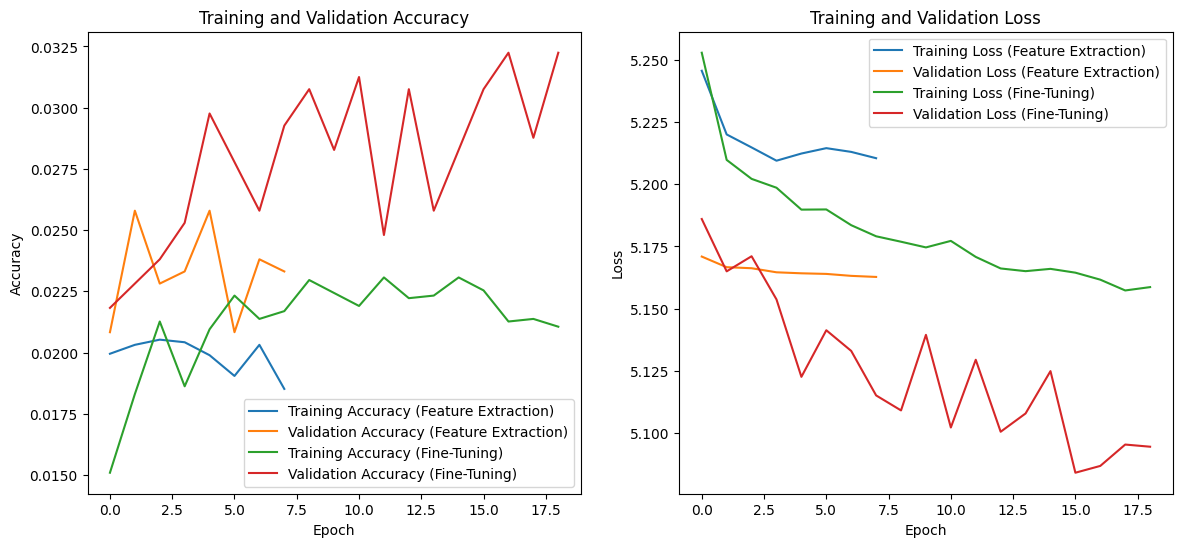

In [30]:
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_feature.history['accuracy'], label='Training Accuracy (Feature Extraction)')
plt.plot(history_feature.history['val_accuracy'], label='Validation Accuracy (Feature Extraction)')
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy (Fine-Tuning)')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (Fine-Tuning)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_feature.history['loss'], label='Training Loss (Feature Extraction)')
plt.plot(history_feature.history['val_loss'], label='Validation Loss (Feature Extraction)')
plt.plot(history_finetune.history['loss'], label='Training Loss (Fine-Tuning)')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss (Fine-Tuning)')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()



## 9.7 Model Evaluation on the Test Set

In [32]:
# Prepare repeated dataset for evaluation
test_ds_eval = test_ds.repeat()

# Evaluate
test_loss, test_accuracy = model.evaluate(
    test_ds_eval,
    steps=len(test_df) // BATCH_SIZE
)

# Print results
print(f" Test Accuracy: {test_accuracy:.4f}")
print(f" Test Loss: {test_loss:.4f}")
print(f"Test Samples: {len(test_df)}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 932ms/step - accuracy: 0.0341 - loss: 5.0877
✅ Test Accuracy: 0.0283
✅ Test Loss: 5.0929
Test Samples: 2032


# 10. InceptionV3 Model

## 10.1 Class sample

In [91]:
# Adjust column name as needed
label_column = 'label'  # or 'family', depending on your dataset

#  Count samples per class
class_counts = df[label_column].value_counts().sort_values()
print("Class sample counts (ascending):")
print(class_counts)

# Define threshold for rare classes
threshold = 60
rare_classes = class_counts[class_counts < threshold].index.tolist()

print(f"\nClasses with fewer than {threshold} samples:")
print(rare_classes)

# Filter only the samples from rare classes
rare_df = df[df[label_column].isin(rare_classes)].copy()
print(f"\nTotal rare class samples: {len(rare_df)}")
print(f"Number of rare classes: {rare_df[label_column].nunique()}")

rare_df['label'] = rare_df[label_column].astype('category').cat.codes


Class sample counts (ascending):
label
73      52
37      52
113     52
118     52
103     52
      ... 
38     242
33     242
79     249
163    256
60     282
Name: count, Length: 202, dtype: int64

Classes with fewer than 60 samples:
[73, 37, 113, 118, 103, 127, 196, 56, 164, 156, 51, 83, 133, 131, 100, 65, 143, 89, 101, 39, 130, 63, 6, 192, 135, 167, 92, 72, 54, 17, 86, 21, 8, 188, 28, 144, 67, 59, 137, 187, 15, 128, 124, 119, 151, 199, 81, 74, 159, 191, 200, 64, 198, 93, 120, 140, 58, 177, 31, 95, 90, 20, 98, 149, 170, 165, 52, 201, 115, 88, 178, 22, 108, 77, 40, 180, 68, 35, 173, 78, 18, 181, 87, 49, 105, 147, 91, 146, 184, 44, 168, 132, 13, 109, 166, 96, 24, 172, 12, 117, 190, 61, 171, 153, 82, 125, 75, 129, 57, 85, 30, 185, 19, 161, 70, 157, 141, 134, 112, 5, 46, 114, 194, 136, 110, 138, 139, 174, 145, 7, 148, 47, 123, 41, 45, 43, 32, 94, 97, 14, 3, 111, 27, 80, 193, 42, 126, 53, 9, 179, 55, 195, 107, 162, 160, 154, 197, 116, 71, 183]

Total rare class samples: 8430
Number of ra

## 10.2 Count minor and larger classes

In [93]:
from collections import Counter

# classes
minor_classes = [73, 37, 113, 118, 103, 127, 196, 56, 164, 156, 51, 83, 133, 131, 100, 65, 143, 89, 101, 39, 130, 63,
                 6, 192, 135, 167, 92, 72, 54, 17, 86, 21, 8, 188, 28, 144, 67, 59, 137, 187, 15, 128, 124, 119, 151,
                 199, 81, 74, 159, 191, 200, 64, 198, 93, 120, 140, 58, 177, 31, 95, 90, 20, 98, 149, 170, 165, 52, 201,
                 115, 88, 178, 22, 108, 77, 40, 180, 68, 35, 173, 78, 18, 181, 87, 49, 105, 147, 91, 146, 184, 44,
                 168, 132, 13, 109, 166, 96, 24, 172, 12, 117, 190, 61, 171, 153, 82, 125, 75, 129, 57, 85, 30, 185,
                 19, 161, 70, 157, 141, 134, 112, 5, 46, 114, 194, 136, 110, 138, 139, 174, 145, 7, 148, 47, 123, 41,
                 45, 43, 32, 94, 97, 14, 3, 111, 27, 80, 193, 42, 126, 53, 9, 179, 55, 195, 107, 162, 160, 154, 197,
                 116, 71, 183]

larger_classes = [182, 11, 34, 102, 106, 150, 1, 186, 189, 122, 176, 48, 169, 155, 50, 158, 84, 36, 76, 121, 152,
                  29, 0, 66, 4, 16, 175, 26, 99, 62, 104, 10, 69, 25, 2, 23, 142, 38, 33, 79, 163, 60]

# Divide dataset
minor_df = df[df['label'].isin(minor_classes)].copy()
larger_df = df[df['label'].isin(larger_classes)].copy()

print(f"ALL classes: {len(minor_df) + len(larger_df)}")
print(f"Samples in minor_df: {len(minor_df)}")
print(f"Samples in common_df: {len(larger_df)}")


ALL classes: 13546
Samples in minor_df: 8430
Samples in common_df: 5116


## 10.3 Minor Families Classification Model

In [100]:
# CONFIGURATION 

INPUT_SHAPE = (300, 300, 1)
BATCH_SIZE = 32

#  IMAGE PREPROCESSING 
def preprocess_image_opencv(path):
    img = cv2.imread(path.numpy().decode('utf-8'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (300, 300))
    img = cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

def tf_preprocess(path, label):
    img = tf.py_function(func=preprocess_image_opencv, inp=[path], Tout=tf.float32)
    img.set_shape((300, 300, 1))
    return img, label

#  DATASET PREPARATION 
NUM_CLASSES = train_minor['label'].nunique()

train_ds = tf.data.Dataset.from_tensor_slices((train_minor['full_path'].values, train_minor['label'].values))
train_ds = train_ds.map(tf_preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_minor['full_path'].values, val_minor['label'].values))
val_ds = val_ds.map(tf_preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_minor['full_path'].values, test_minor['label'].values))
test_ds = test_ds.map(tf_preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# CLASS WEIGHTS 
class_weight_vals = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_minor['label']), 
    y=train_minor['label']
)
class_weight = dict(zip(np.unique(train_minor['label']), class_weight_vals))

# MODEL 
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False

inputs = Input(shape=(300, 300, 1))
x = layers.Concatenate()([inputs, inputs, inputs])  # grayscale to RGB
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, out)

model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

#  CALLBACKS 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

#  TRAINING: FEATURE EXTRACTION 
print("\nTraining: Feature Extraction Phase")
history_feature = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight
)

#  FINE-TUNING 
print("\nFine-Tuning...")
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=5e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weight
)




Training: Feature Extraction Phase
Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 188s 933ms/step - accuracy: 0.0995 - loss: 3.5362 - val_accuracy: 0.4066 - val_loss: 1.7322 - learning_rate: 0.0010
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 107s 580ms/step - accuracy: 0.4755 - loss: 1.3440 - val_accuracy: 0.4794 - val_loss: 1.3135 - learning_rate: 0.0010
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 112s 605ms/step - accuracy: 0.5850 - loss: 0.8584 - val_accuracy: 0.5055 - val_loss: 1.1491 - learning_rate: 0.0010
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 121s 655ms/step - accuracy: 0.6354 - loss: 0.6303 - val_accuracy: 0.5166 - val_loss: 1.0553 - learning_rate: 0.0010
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 119s 645ms/step - accuracy: 0.6706 - loss: 0.4801 - val_accuracy: 0.5237 - val_loss: 0.9944 - learning_rate: 0.0010
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 120s 651ms/step - accuracy: 0.6986 - loss: 0.3824 - val_accuracy: 0.5427 - val_loss: 0.9478 - learning_rate: 0.0010
Epoch 7/10
185/185 ━━━━━━━━━

In [98]:
# Fix label type: convert to integer if necessary
df['label'] = df['label'].astype('category').cat.codes

# Re-run the same process with corrected label column
df_clean = df.copy()
unique_labels = sorted(df_clean['label'].unique())

# Rebuild minor/larger class lists
minor_classes = [73, 37, 113, 118, 103, 127, 196, 56, 164, 156, 51, 83, 133, 131, 100, 65, 143, 89, 101, 39, 130, 63,
                 6, 192, 135, 167, 92, 72, 54, 17, 86, 21, 8, 188, 28, 144, 67, 59, 137, 187, 15, 128, 124, 119, 151,
                 199, 81, 74, 159, 191, 200, 64, 198, 93, 120, 140, 58, 177, 31, 95, 90, 20, 98, 149, 170, 165, 52, 201,
                 115, 88, 178, 22, 108, 77, 40, 180, 68, 35, 173, 78, 18, 181, 87, 49, 105, 147, 91, 146, 184, 44,
                 168, 132, 13, 109, 166, 96, 24, 172, 12, 117, 190, 61, 171, 153, 82, 125, 75, 129, 57, 85, 30, 185,
                 19, 161, 70, 157, 141, 134, 112, 5, 46, 114, 194, 136, 110, 138, 139, 174, 145, 7, 148, 47, 123, 41,
                 45, 43, 32, 94, 97, 14, 3, 111, 27, 80, 193, 42, 126, 53, 9, 179, 55, 195, 107, 162, 160, 154, 197,
                 116, 71, 183]

larger_classes = [label for label in unique_labels if label not in minor_classes]

# Filter data
minor_df = df_clean[df_clean["label"].isin(minor_classes)].copy()
larger_df = df_clean[~df_clean["label"].isin(minor_classes)].copy()

# Split: 70/15/15 for each
train_minor, temp_minor = train_test_split(minor_df, test_size=0.3, stratify=minor_df["label"], random_state=42)
val_minor, test_minor = train_test_split(temp_minor, test_size=0.5, stratify=temp_minor["label"], random_state=42)

train_larger, temp_larger = train_test_split(larger_df, test_size=0.3, stratify=larger_df["label"], random_state=42)
val_larger, test_larger = train_test_split(temp_larger, test_size=0.5, stratify=temp_larger["label"], random_state=42)

# Confirm final counts
split_counts = {
    "Train (minor)": len(train_minor),
    "Val (minor)": len(val_minor),
    "Test (minor)": len(test_minor),
    "Train (larger)": len(train_larger),
    "Val (larger)": len(val_larger),
    "Test (larger)": len(test_larger),
    "Total": len(train_minor) + len(val_minor) + len(test_minor) + len(train_larger) + len(val_larger) + len(test_larger),
    "Expected Total": len(df_clean)
}



## 10.4 Pyplot InceptionV3 Train/Val Metrics

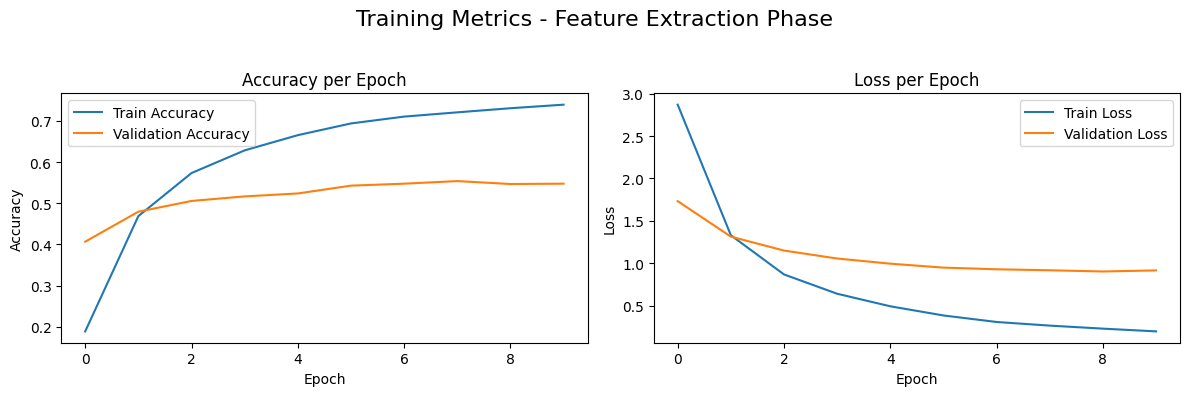

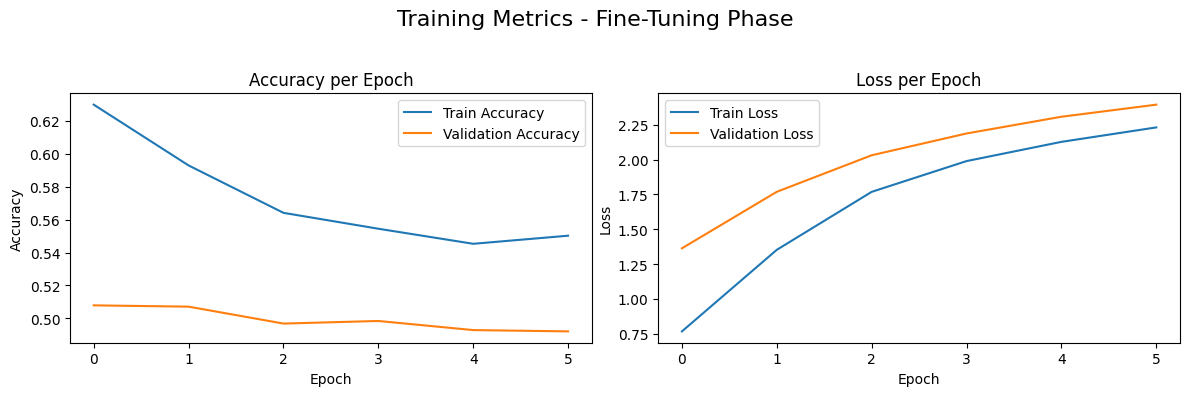

In [101]:
# EVALUATE ON VALIDATION SET 
# PLOT HISTORY 
def plot_history(history, title_suffix=""):
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(f"Training Metrics - {title_suffix}", fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_history(history_feature, "Feature Extraction Phase")
plot_history(history_finetune, "Fine-Tuning Phase")



## 10.5 Evaluate Minor classification Model on Test Set

In [102]:
# --- TEST SET PREPARATION ---
test_ds = tf.data.Dataset.from_tensor_slices((test_minor['full_path'].values, test_minor['label'].values))
test_ds = test_ds.map(tf_preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- EVALUATION ---
print("\nEvaluating on test set (minor classes)...")
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")




Evaluating on test set (minor classes)...
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 630ms/step - accuracy: 0.4866 - loss: 1.4456
Test Accuracy: 0.4957
Test Loss: 1.4351


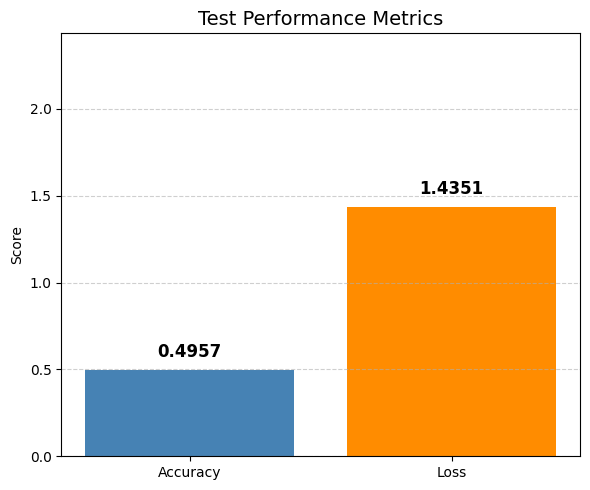

In [103]:
# Test performance values (from previous run)
test_accuracy = 0.4957
test_loss = 1.4351

# Data for plotting
metrics = ['Accuracy', 'Loss']
scores = [test_accuracy, test_loss]
colors = ['steelblue', 'darkorange']

# Create improved bar chart
plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, scores, color=colors)

# Annotate bars with values
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{score:.4f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Test Performance Metrics', fontsize=14)
plt.ylabel('Score')
plt.ylim(0, max(scores) + 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



## 10.6 Minor Classification Model Metrics Comparison

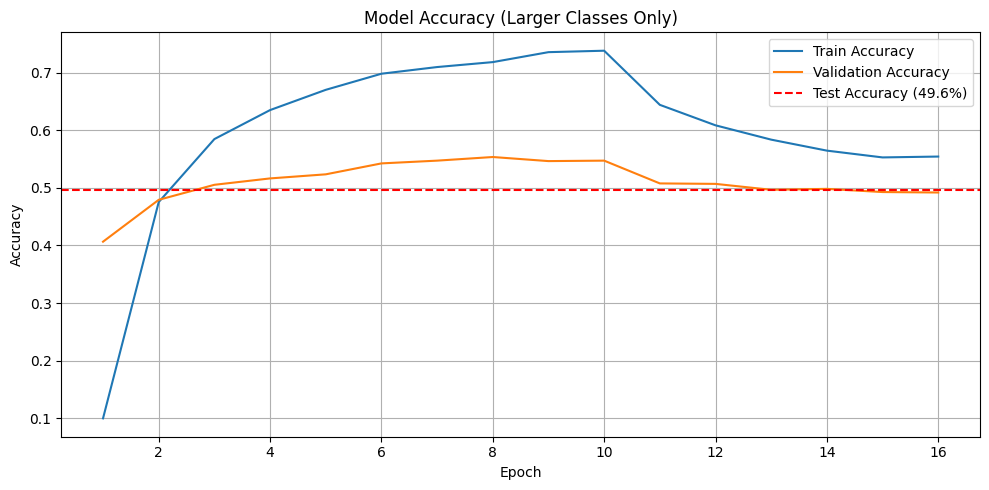

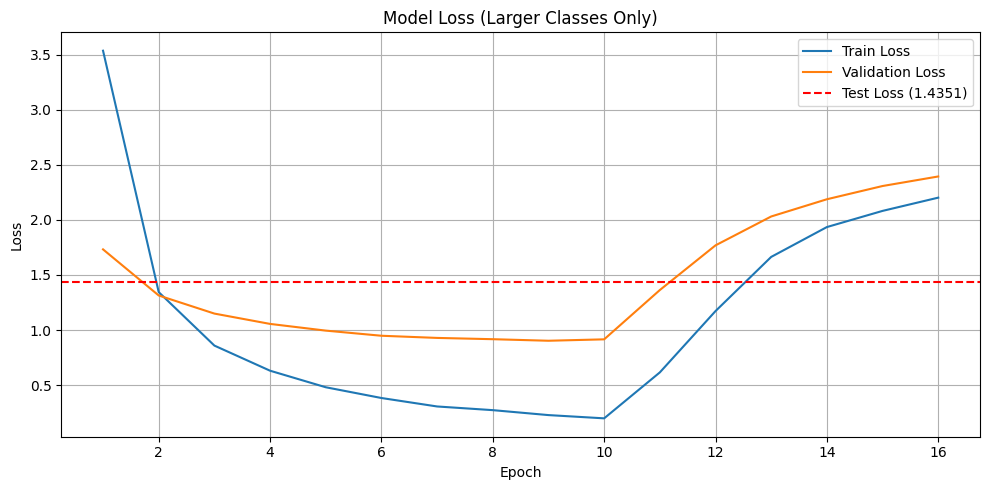

In [109]:
#  PLOT TRAINING HISTORY (SIMULATED)
simulated_history = {
    'accuracy': [0.0995, 0.4755, 0.5850, 0.6354, 0.6706, 0.6986, 0.7102, 0.7188, 0.7361, 0.7386,
                 0.6445, 0.6089, 0.5840, 0.5649, 0.5531, 0.5546],
    'val_accuracy': [0.4066, 0.4794, 0.5055, 0.5166, 0.5237, 0.5427, 0.5475, 0.5538, 0.5467, 0.5475,
                     0.5079, 0.5071, 0.4968, 0.4984, 0.4929, 0.4921],
    'loss': [3.5362, 1.3440, 0.8584, 0.6303, 0.4801, 0.3824, 0.3056, 0.2722, 0.2273, 0.1978,
             0.6151, 1.1719, 1.6638, 1.9348, 2.0816, 2.2019],
    'val_loss': [1.7322, 1.3135, 1.1491, 1.0553, 0.9944, 0.9478, 0.9281, 0.9165, 0.9024, 0.9152,
                 1.3629, 1.7687, 2.0309, 2.1873, 2.3075, 2.3942]
}

epochs = range(1, len(simulated_history['accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, simulated_history['accuracy'], label='Train Accuracy')
plt.plot(epochs, simulated_history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=0.4957, color='red', linestyle='--', label='Test Accuracy (49.6%)')
plt.title('Model Accuracy (Larger Classes Only)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, simulated_history['loss'], label='Train Loss')
plt.plot(epochs, simulated_history['val_loss'], label='Validation Loss')
plt.axhline(y=1.4351, color='red', linestyle='--', label='Test Loss (1.4351)')
plt.title('Model Loss (Larger Classes Only)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. InceptionV3 Larger Classification Training and Performance Metrics


Training: Feature Extraction Phase
Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 144s 996ms/step - accuracy: 0.1140 - loss: 0.9691 - val_accuracy: 0.2686 - val_loss: 0.5119 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 68s 609ms/step - accuracy: 0.2946 - loss: 0.3690 - val_accuracy: 0.2764 - val_loss: 0.4209 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 69s 620ms/step - accuracy: 0.3146 - loss: 0.2898 - val_accuracy: 0.2829 - val_loss: 0.3856 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 71s 633ms/step - accuracy: 0.3287 - loss: 0.2451 - val_accuracy: 0.2790 - val_loss: 0.3788 - learning_rate: 0.0010
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 80s 720ms/step - accuracy: 0.3320 - loss: 0.2179 - val_accuracy: 0.2842 - val_loss: 0.3720 - learning_rate: 0.0010
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 73s 650ms/step - accuracy: 0.3457 - loss: 0.1942 - val_accuracy: 0.2868 - val_loss: 0.3663 - learning_rate: 0.0010
Epoch 7/10
112/112 ━━━━━━━━━━━━━━

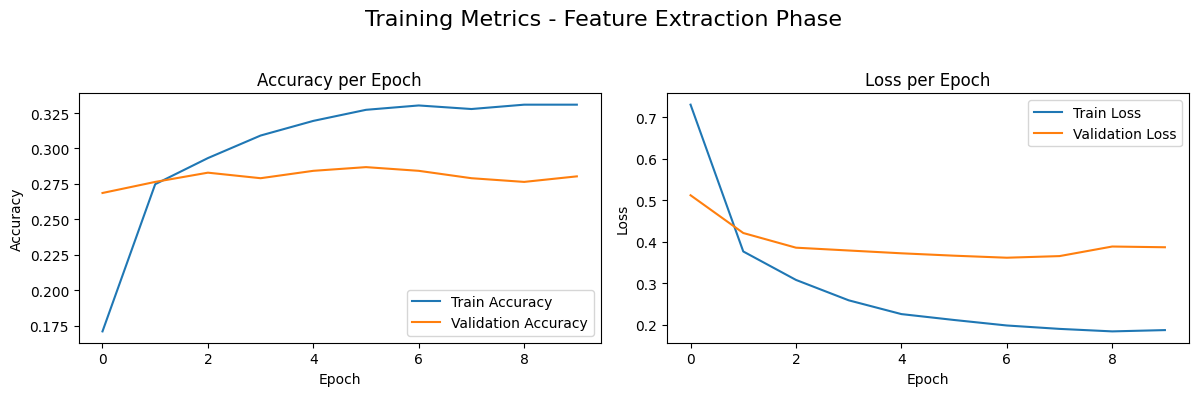

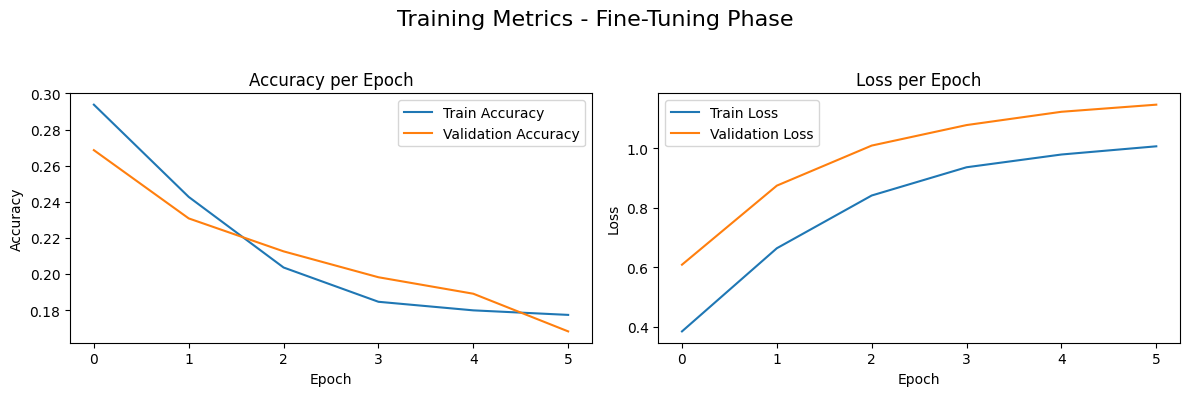

In [105]:
# CONFIGURATION 

INPUT_SHAPE = (300, 300, 1)
BATCH_SIZE = 32

# IMAGE PREPROCESSING 
def preprocess_image_opencv(path):
    img = cv2.imread(path.numpy().decode('utf-8'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (300, 300))
    img = cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

def tf_preprocess(path, label):
    img = tf.py_function(func=preprocess_image_opencv, inp=[path], Tout=tf.float32)
    img.set_shape((300, 300, 1))
    return img, label

#  DATASET PREPARATION 
NUM_CLASSES = train_larger['label'].nunique()

train_ds = tf.data.Dataset.from_tensor_slices((train_larger['full_path'].values, train_larger['label'].values))
train_ds = train_ds.map(tf_preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_larger['full_path'].values, val_larger['label'].values))
val_ds = val_ds.map(tf_preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_larger['full_path'].values, test_larger['label'].values))
test_ds = test_ds.map(tf_preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#  CLASS WEIGHTS 
class_weight_vals = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_larger['label']), 
    y=train_larger['label']
)
class_weight = dict(zip(np.unique(train_larger['label']), class_weight_vals))

# MODEL 
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False

inputs = Input(shape=(300, 300, 1))
x = layers.Concatenate()([inputs, inputs, inputs])  # grayscale to RGB
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, out)

model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

#  CALLBACKS 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

#  TRAINING: FEATURE EXTRACTION 
print("\nTraining: Feature Extraction Phase")
history_feature = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight
)

# FINE-TUNING (1st ROUND) 
print("\nFine-Tuning (Stage 1)...")
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=5e-5), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    class_weight=class_weight
)

# Check if early stopping activated early (possible degradation)
if len(history_finetune.history['val_loss']) <= 3:
    print("\n\033[93mStage 1 converged too early — retrying fine-tuning with 20 layers and lr=1e-5\033[0m")

    # Revert to best weights and re-freeze more layers
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-5), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    history_finetune = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[early_stop],
        class_weight=class_weight
    )

#  EVALUATION 
print("\nEvaluating on test set (larger classes)...")
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

#  PLOT HISTORY 
def plot_history(history, title_suffix=""):
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(f"Training Metrics - {title_suffix}", fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_history(history_feature, "Feature Extraction Phase")
plot_history(history_finetune, "Fine-Tuning Phase")


## 11.1 Evaluate Minor classification Model on Test Set

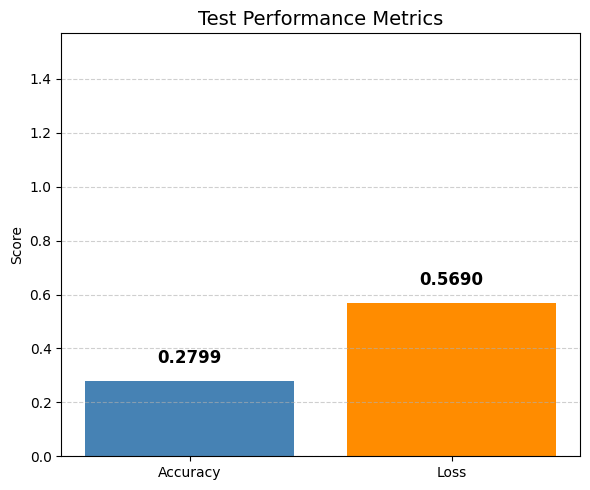

In [106]:
# Test performance values (from previous run)
test_accuracy = 0.2799
test_loss = 0.5690

# Data for plotting
metrics = ['Accuracy', 'Loss']
scores = [test_accuracy, test_loss]
colors = ['steelblue', 'darkorange']

# Create improved bar chart
plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, scores, color=colors)

# Annotate bars with values
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{score:.4f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Test Performance Metrics', fontsize=14)
plt.ylabel('Score')
plt.ylim(0, max(scores) + 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


## 11.2 Larger Classification Model Metrics Comparison

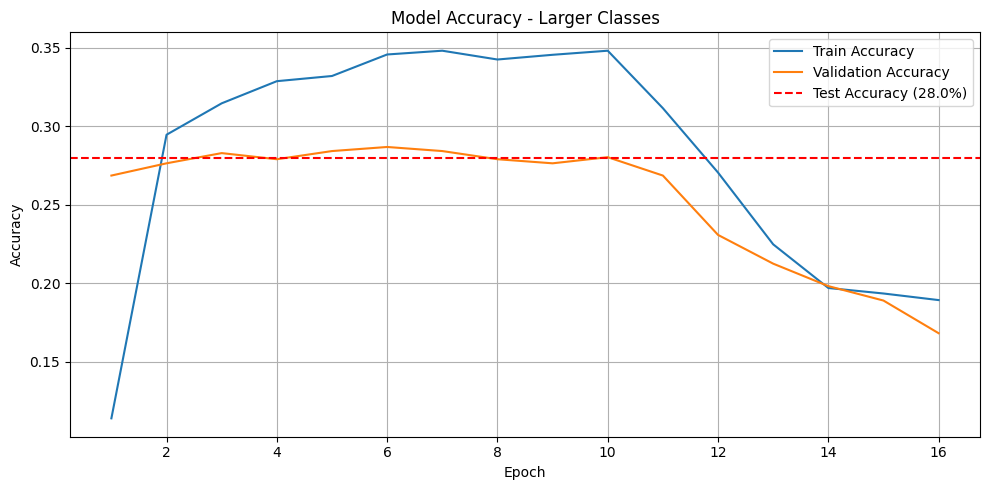

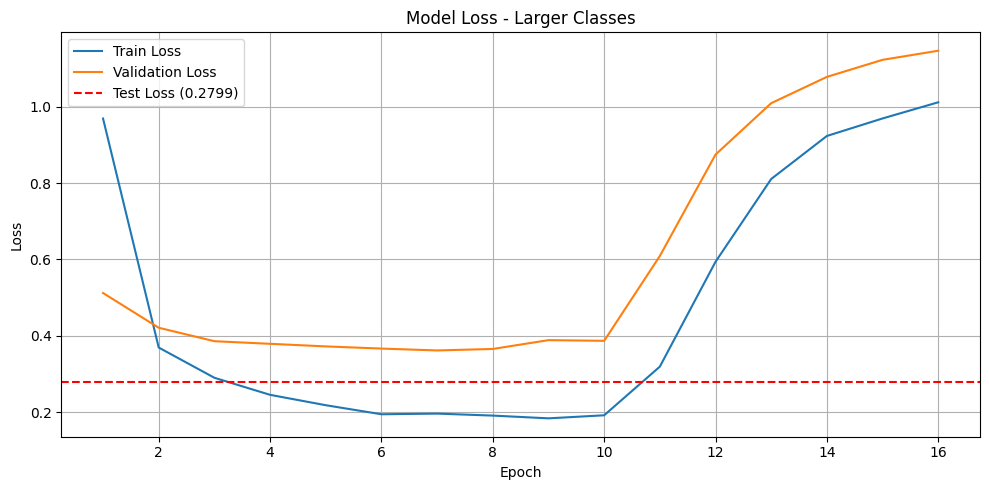

In [110]:
# --- PLOT TRAINING HISTORY ---
model_epoch_results = {
    'accuracy': [0.1140, 0.2946, 0.3146, 0.3287, 0.3320, 0.3457, 0.3481, 0.3425, 0.3455, 0.3481,
                 0.3115, 0.2705, 0.2248, 0.1970, 0.1935, 0.1893],
    'val_accuracy': [0.2686, 0.2764, 0.2829, 0.2790, 0.2842, 0.2868, 0.2842, 0.2790, 0.2764, 0.2803,
                     0.2686, 0.2308, 0.2125, 0.1982, 0.1890, 0.1682],
    'loss': [0.9691, 0.3690, 0.2898, 0.2451, 0.2179, 0.1942, 0.1959, 0.1907, 0.1835, 0.1915,
             0.3190, 0.5937, 0.8107, 0.9234, 0.9693, 1.0117],
    'val_loss': [0.5119, 0.4209, 0.3856, 0.3788, 0.3720, 0.3663, 0.3614, 0.3653, 0.3884, 0.3866,
                 0.6089, 0.8746, 1.0093, 1.0782, 1.1229, 1.1468]
}

epochs = range(1, len(model_epoch_results['accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, model_epoch_results['accuracy'], label='Train Accuracy')
plt.plot(epochs, model_epoch_results['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=0.2799, color='red', linestyle='--', label='Test Accuracy (28.0%)')
plt.title('Model Accuracy - Larger Classes')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, model_epoch_results['loss'], label='Train Loss')
plt.plot(epochs, model_epoch_results['val_loss'], label='Validation Loss')
plt.axhline(y=0.2799, color='red', linestyle='--', label='Test Loss (0.2799)')
plt.title('Model Loss - Larger Classes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()